### Introduction
Deciding whether a used car is worth the posted price when you see listings online can be difficult. Several factors,
including mileage, make, model, year, etc. can influence the actual worth of a car. From the perspective of a seller, it is also a dilemma to price a used car appropriately. Based on existing data, the aim is to use machine learning algorithms to develop models for predicting used car prices.

###  Importing necessary Libraries

In [160]:
# !conda install -c conda-forge pycaret --yes
# !conda install -c conda-forge scikit-plot --yes

In [161]:
import pandas as pd #tabular data analysis and manipulation
import numpy as np #vectorization and array manipulation
import statsmodels.api as sm#statistical test
from scipy import stats #statistical test
from statsmodels.formula.api import ols #statistical test
import seaborn as sns #statistical data visualization
import matplotlib.pyplot as plt #statistical data visualization
from sklearn import preprocessing #utility to change raw feature vectors into representations, more suitable for downstream estimators.
from sklearn import impute #replace missing values
from sklearn import model_selection #create folds, tune hyperparameters, split data
from sklearn import linear_model #models where target is linearly dependent with the features
from sklearn import svm #support vector machines
from sklearn import tree # tree based algorithms
from sklearn import ensemble #Multiple trees based algorithms
# from pycaret.regression import * #data impute,data transformation, model fit, hyperparameter tuning
import warnings
warnings.filterwarnings('ignore')

In [162]:
# path defined for the train data and test data
train_path = './usedCarData/train.csv'
test_path = './usedCarData/test.csv'

In [163]:
# reading the train data file
train_df = pd.read_csv(train_path)

In [164]:
#first five rows of train data
train_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


### Preprocessing Data

In [165]:
#Organize the column names which will help us to call them in easy way
train_df.columns = ['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'ProdYear',
       'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage',
       'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color',
       'Airbags']

The data above provides us with attributes of a car like Manufacturer, manufatured year, Category, Odometer value which will help us to predict the price of the car. Let us check the percentage of missing rows for each feature in the data.

In [166]:
#percentage of missing values.Missing values may be present in some different forms
train_df.isna().mean()

ID                 0.0
Price              0.0
Levy               0.0
Manufacturer       0.0
Model              0.0
ProdYear           0.0
Category           0.0
LeatherInterior    0.0
FuelType           0.0
EngineVolume       0.0
Mileage            0.0
Cylinders          0.0
GearBoxType        0.0
DriveWheels        0.0
Doors              0.0
Wheel              0.0
Color              0.0
Airbags            0.0
dtype: float64

In [167]:
#selecting only object columns
#few numerical columns like Levy, Mileage, Doors are represented as object columns which we have to convert to numerical.
#Column Levy has hyphen as missing values, Mileage has km attached to it
train_df.select_dtypes('object').head()

,Levy,Manufacturer,Model,Category,LeatherInterior,FuelType,EngineVolume,Mileage,GearBoxType,DriveWheels,Doors,Wheel,Color
0,1399,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005 km,Automatic,4x4,04-May,Left wheel,Silver
1,1018,CHEVROLET,Equinox,Jeep,No,Petrol,3,192000 km,Tiptronic,4x4,04-May,Left wheel,Black
2,-,HONDA,FIT,Hatchback,No,Petrol,1.3,200000 km,Variator,Front,04-May,Right-hand drive,Black
3,862,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966 km,Automatic,4x4,04-May,Left wheel,White
4,446,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901 km,Automatic,Front,04-May,Left wheel,Silver


In [168]:
train_df.Levy = train_df.Levy.replace('-',np.nan).astype('float') # converting hyphen to NaN and changing the column data type to float
train_df.Mileage = train_df.Mileage.replace(' km', '', regex=True).astype('int') # converting Mileage to integer data type

train_df['Turbo'] = np.where(train_df.EngineVolume.str.contains('Turbo'), 1,0) #creating column Turbo for Turbo engines

In [169]:
#Lets check Engine Volume, Drive wheels and Doors
train_df.EngineVolume.unique() # engines are Turbo and normal

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

In [170]:
#Remving Turbo from the Engine Volume
train_df.EngineVolume = train_df.EngineVolume.replace(' Turbo','', regex=True).astype('float')

In [171]:
train_df.DriveWheels.unique() #Three drive wheels

array(['4x4', 'Front', 'Rear'], dtype=object)

In [172]:
train_df.Doors.unique() # Three kinds of Doors. Some cleaning is needed here.

array(['04-May', '02-Mar', '>5'], dtype=object)

In [173]:
train_df.Doors = train_df.Doors.replace(r'-[a-zA-Z]{3}','',regex=True)# using regex to clean Doors

In [174]:
train_df.Doors.unique() #unique doors

array(['04', '02', '>5'], dtype=object)

In [175]:
# lets look at the non-object columns, Mileage and levy are now numerical columns
train_df[train_df.select_dtypes(exclude='object').columns].head()

,ID,Price,Levy,ProdYear,EngineVolume,Mileage,Cylinders,Airbags,Turbo
0,45654403,13328,1399.0,2010,3.5,186005,6.0,12,0
1,44731507,16621,1018.0,2011,3.0,192000,6.0,8,0
2,45774419,8467,NaN,2006,1.3,200000,4.0,2,0
3,45769185,3607,862.0,2011,2.5,168966,4.0,0,0
4,45809263,11726,446.0,2014,1.3,91901,4.0,4,0


In [176]:
#drop the ID column
train_df.drop('ID', axis =1, inplace=True)

In [177]:
#Check for duplicates, 3512 duplicate rows are present, we can drop them by keeping one of them
train_df[train_df.duplicated()].shape

(3512, 18)

In [178]:
train_df.drop_duplicates(keep='first', inplace=True) # removing duplicates

In [179]:
#check the percentage of missing values
train_df.isna().mean()

Price              0.000000
Levy               0.361463
Manufacturer       0.000000
Model              0.000000
ProdYear           0.000000
Category           0.000000
LeatherInterior    0.000000
FuelType           0.000000
EngineVolume       0.000000
Mileage            0.000000
Cylinders          0.000000
GearBoxType        0.000000
DriveWheels        0.000000
Doors              0.000000
Wheel              0.000000
Color              0.000000
Airbags            0.000000
Turbo              0.000000
dtype: float64

* 36% of the levy data is missing

In [180]:
train_df.head()

,Price,Levy,Manufacturer,Model,ProdYear,Category,LeatherInterior,FuelType,EngineVolume,Mileage,Cylinders,GearBoxType,DriveWheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04,Left wheel,Silver,12,0
1,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,04,Left wheel,Black,8,0
2,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04,Right-hand drive,Black,2,0
3,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04,Left wheel,White,0,0
4,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04,Left wheel,Silver,4,0


In [181]:
# since we did not reset the index, we can see that initially there were 19,237 entries and after removing duplicates
# there are 15725
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15725 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            15725 non-null  int64  
 1   Levy             10041 non-null  float64
 2   Manufacturer     15725 non-null  object 
 3   Model            15725 non-null  object 
 4   ProdYear         15725 non-null  int64  
 5   Category         15725 non-null  object 
 6   LeatherInterior  15725 non-null  object 
 7   FuelType         15725 non-null  object 
 8   EngineVolume     15725 non-null  float64
 9   Mileage          15725 non-null  int64  
 10  Cylinders        15725 non-null  float64
 11  GearBoxType      15725 non-null  object 
 12  DriveWheels      15725 non-null  object 
 13  Doors            15725 non-null  object 
 14  Wheel            15725 non-null  object 
 15  Color            15725 non-null  object 
 16  Airbags          15725 non-null  int64  
 17  Turbo       

**Check the Outliers**

In [182]:
#Convert the year column to age and check the outliers

train_df.ProdYear = 2021 - train_df.ProdYear

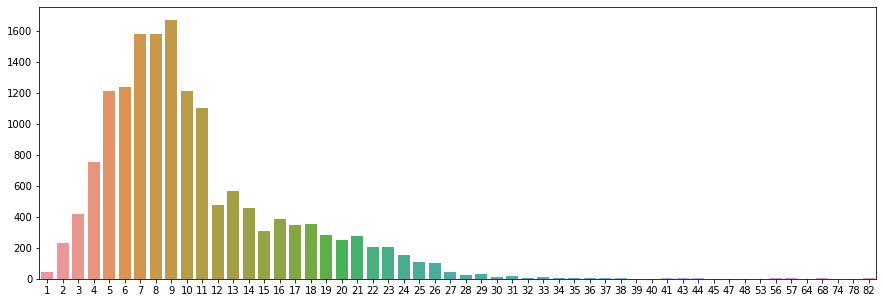

In [183]:
plt.figure(figsize=(15,5))
sns.barplot(train_df.ProdYear.value_counts().index,train_df.ProdYear.value_counts().values);

In [184]:
train_df.ProdYear.quantile([0.01, 0.99])

0.01     2.0
0.99    27.0
Name: ProdYear, dtype: float64

From the above graph we can see that cars above age 30 dont make a big contribution, also cars with age<=27 constitues more
tha 99% of tha data.

In [185]:
train_df = train_df[train_df.ProdYear<=30]

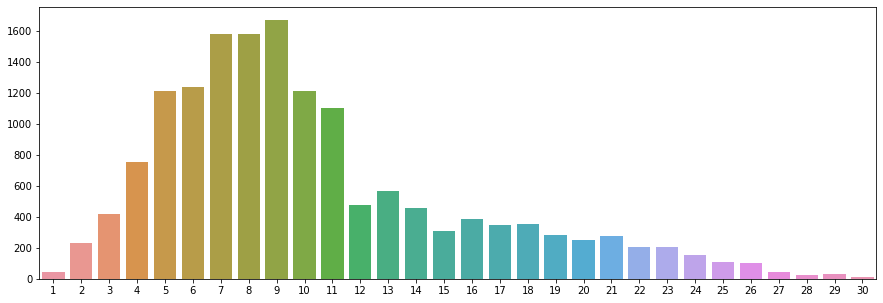

In [186]:
#after removing outliers
plt.figure(figsize=(15,5))
sns.barplot(train_df.ProdYear.value_counts().index,train_df.ProdYear.value_counts().values);

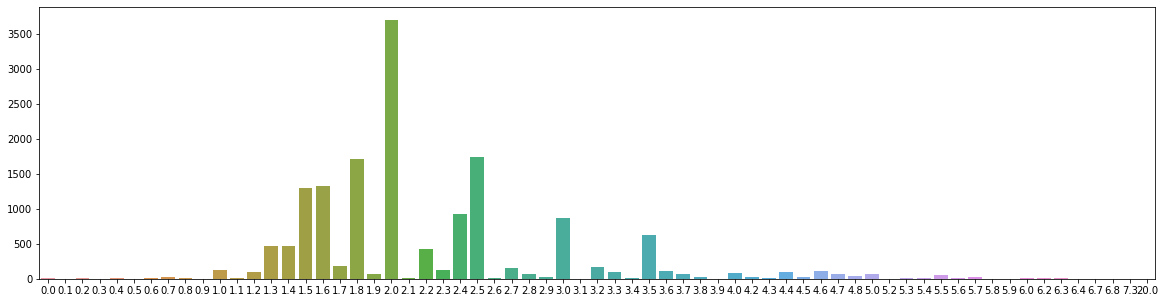

In [187]:
#Checking outliers in Engine volume
plt.figure(figsize=(20,5))
sns.barplot(train_df.EngineVolume.value_counts().index,train_df.EngineVolume.value_counts().values);

Lot of Engine Volume are present which are very less in numbers, lets check the count of each engine

In [188]:
# collecting engines with count less than or equal to 10
engineCount = pd.DataFrame(train_df.EngineVolume.value_counts()).reset_index()
engineCount.columns = ['Engine','Count']
dropEngine = engineCount[engineCount.Count<=10]['Engine'].values
dropEngine

array([ 2.1,  6.2,  0. ,  0.2,  5.3,  3.4,  1.1,  0.8,  5.4,  0.4,  6.3,
        5.6,  6. ,  0.6,  0.1,  5.9,  6.4,  3.9,  6.7,  5.2,  0.3,  0.9,
        6.8,  3.1,  7.3,  0.5, 20. ,  5.8])

In [189]:
# droppping the engine
train_df = train_df[~train_df.EngineVolume.isin(dropEngine)]

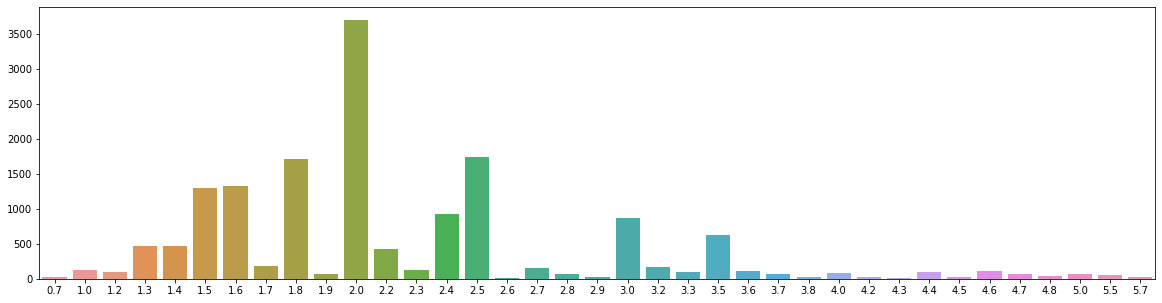

In [190]:
#after dropping the outliers from engine volume
plt.figure(figsize=(20,5))
sns.barplot(train_df.EngineVolume.value_counts().index,train_df.EngineVolume.value_counts().values);

In [191]:
# In category it seems better to combine Pickup, Cabriolet and Limousine
train_df.Category.value_counts()

Sedan          6924
Jeep           4172
Hatchback      2530
Minivan         531
Coupe           456
Universal       307
Microbus        287
Goods wagon     227
Pickup           49
Cabriolet        31
Limousine         5
Name: Category, dtype: int64

In [192]:
#Combine all three categories to PCL category
train_df.Category = train_df.Category.apply(lambda x: 'PCL' if x in ('Pickup','Cabriolet','Limousine') else x)
train_df.Category.value_counts()

Sedan          6924
Jeep           4172
Hatchback      2530
Minivan         531
Coupe           456
Universal       307
Microbus        287
Goods wagon     227
PCL              85
Name: Category, dtype: int64

In [193]:
#We can apply the same procedure which we applied to the Engine Volume. Remove count less than a threshold value
train_df.Manufacturer.value_counts().tail(30)

VOLVO           19
PEUGEOT         16
ACURA           15
BUICK           15
DAIHATSU        13
CADILLAC        12
LINCOLN         10
GMC             10
CITROEN          9
SCION            7
GAZ              5
ISUZU            4
MASERATI         4
MERCURY          4
ALFA ROMEO       4
UAZ              3
ROVER            3
HUMMER           3
სხვა             2
SEAT             2
SAAB             2
HAVAL            1
LANCIA           1
BENTLEY          1
FERRARI          1
LAMBORGHINI      1
PONTIAC          1
SATURN           1
ASTON MARTIN     1
GREATWALL        1
Name: Manufacturer, dtype: int64

In [194]:
#manufacturers with count less than or equal to 10
manufacturerCount = pd.DataFrame(train_df.Manufacturer.value_counts()).reset_index()
manufacturerCount.columns = ['Manufacturer','Count']
dropManufacturer= manufacturerCount[manufacturerCount.Count<=10]['Manufacturer'].values
dropManufacturer

array(['LINCOLN', 'GMC', 'CITROEN', 'SCION', 'GAZ', 'ISUZU', 'MASERATI',
       'MERCURY', 'ALFA ROMEO', 'UAZ', 'ROVER', 'HUMMER', 'სხვა', 'SEAT',
       'SAAB', 'HAVAL', 'LANCIA', 'BENTLEY', 'FERRARI', 'LAMBORGHINI',
       'PONTIAC', 'SATURN', 'ASTON MARTIN', 'GREATWALL'], dtype=object)

In [195]:
train_df = train_df[~train_df.Manufacturer.isin(dropManufacturer)]

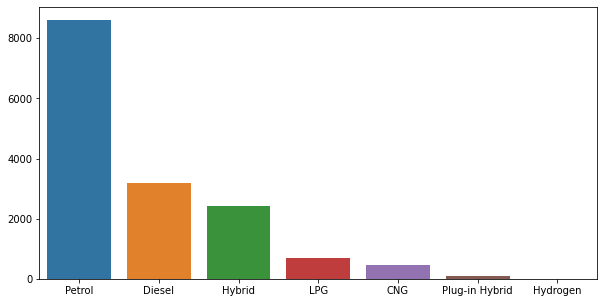

In [196]:
#Fuel type
#We can combine hybrid and PlugIn Hybris. another group can be made of LPG, CNG and Hydrogen
plt.figure(figsize=(10,5))
sns.barplot(train_df.FuelType.value_counts().index, train_df.FuelType.value_counts().values);

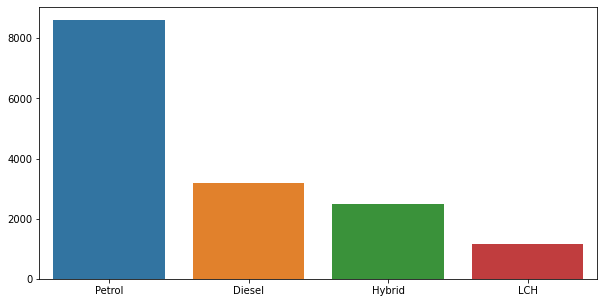

In [197]:
#After grouping the fuel Types
train_df.FuelType = train_df.FuelType.apply(lambda x: 'Hybrid' if x=='Plug-in Hybrid' else x)
train_df.FuelType = train_df.FuelType.apply(lambda x: 'LCH' if x in ('LPG','CNG','Hydrogen') else x)

plt.figure(figsize=(10,5))
sns.barplot(train_df.FuelType.value_counts().index, train_df.FuelType.value_counts().values);

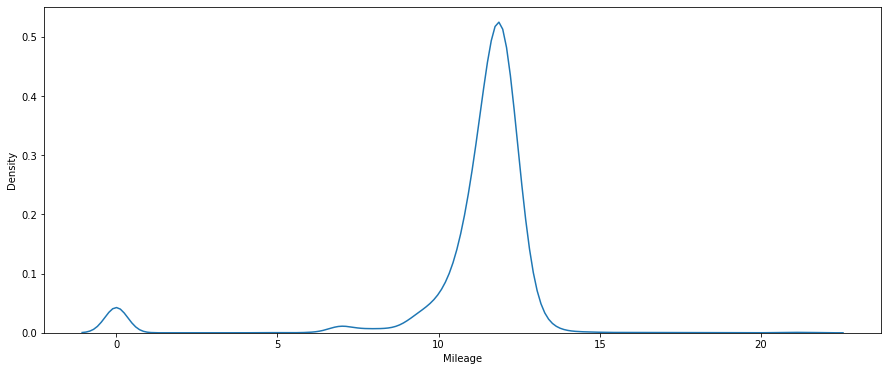

In [198]:
#log transformation of Mileage
plt.figure(figsize=(15,6))
sns.kdeplot(np.log1p(train_df.Mileage));

In [199]:
#check the outliers of Mileage, Removing Mileage greater than or equal to 576972
train_df.Mileage.quantile([0.01, 0.99])

0.01         0.00
0.99    576887.24
Name: Mileage, dtype: float64

In [200]:
#After removing  outliers from Mileage
train_df = train_df[train_df.Mileage<576972]
train_df.shape

(15283, 18)

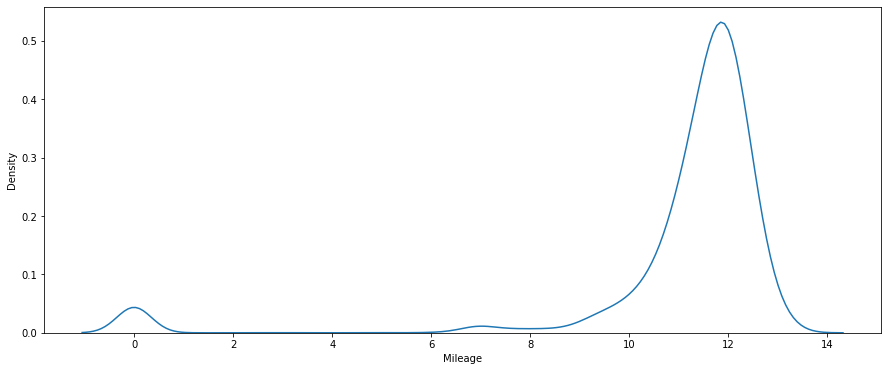

In [201]:
#log transformation of Mileage after removing outliers from the right end
#We msut trat 0 values of Mileage column before removing outliers from the left end, else we will lose data
plt.figure(figsize=(15,6))
sns.kdeplot(np.log1p(train_df.Mileage));

In [202]:
#Mileage is correlated with ProdYear, we can use ProdYear column to impute the 0 values in Mileaage
# Also cylinders and engine volume are higly correlated, and since engline volume is correlated more with price
train_df[['Mileage','ProdYear','Price','Levy','EngineVolume','Cylinders']].corr()

,Mileage,ProdYear,Price,Levy,EngineVolume,Cylinders
Mileage,1.000000,0.265077,-0.021156,-0.003748,0.105321,0.073105
ProdYear,0.265077,1.000000,-0.013411,0.216294,0.075837,0.135136
Price,-0.021156,-0.013411,1.000000,0.074603,0.011875,0.008344
Levy,-0.003748,0.216294,0.074603,1.000000,0.541458,0.471151
EngineVolume,0.105321,0.075837,0.011875,0.541458,1.000000,0.742600
Cylinders,0.073105,0.135136,0.008344,0.471151,0.742600,1.000000


In [203]:
#replacing 0 with nan
train_df.Mileage = train_df.Mileage.replace(0, np.nan)

In [204]:
#aggregating ProdYear and car category to find median price and filling nan values of mileage
train_df.Mileage = train_df.Mileage.fillna(train_df.groupby(['ProdYear','Category'])['Price'].transform('median'))

In [205]:
#Checkin the quantile to remove the outliers from the left end
train_df.Mileage.quantile([0.02,0.99])

0.02      4547.50
0.99    418835.48
Name: Mileage, dtype: float64

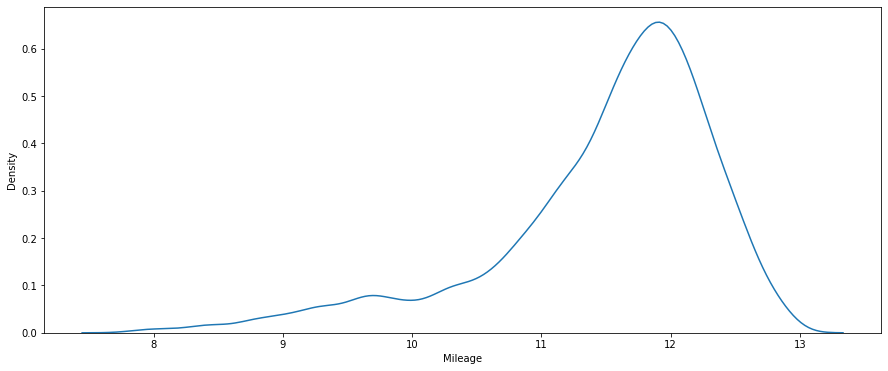

In [206]:
#removing outliers
train_df = train_df[(train_df.Mileage>=2500) & (train_df.Mileage<=418835)]

plt.figure(figsize=(15,6))
sns.kdeplot(np.log1p(train_df.Mileage));

In [208]:
#Cylinders, Group together cylinders values less than or equal to 161
train_df.Cylinders.value_counts()

4.0     11723
6.0      2303
8.0       529
5.0       156
3.0        96
2.0        35
12.0       31
1.0        25
10.0       12
16.0        5
7.0         3
9.0         1
14.0        1
Name: Cylinders, dtype: int64

In [209]:
#Grouping ess occuring cylinder values into other category
train_df.Cylinders = train_df.Cylinders.apply(lambda x: 'other' if x in (3.0,2.0,12.0,1.0,10.0,
                                                                            16.0,7.0,9.0,14.0) else x)

train_df.Cylinders.value_counts()

4.0      11723
6.0       2303
8.0        529
other      209
5.0        156
Name: Cylinders, dtype: int64

In [212]:
train_df.GearBoxType.value_counts()

Automatic    9661
Tiptronic    2961
Manual       1585
Variator      713
Name: GearBoxType, dtype: int64

In [379]:
#almost 30% missing values in Levy
test_df.isna().mean()

Levy               0.297635
Manufacturer       0.000000
Model              0.000000
ProdYear           0.000000
Category           0.000000
LeatherInterior    0.000000
FuelType           0.000000
EngineVolume       0.000000
Mileage            0.000000
Cylinders          0.000000
GearBoxType        0.000000
DriveWheels        0.000000
Doors              0.000000
Wheel              0.000000
Color              0.000000
Airbags            0.000000
Price              1.000000
dtype: float64

In [380]:
test_df.info() #datatypes and nun null values features of test set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8245 entries, 0 to 8244
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Levy             5791 non-null   float64
 1   Manufacturer     8245 non-null   object 
 2   Model            8245 non-null   object 
 3   ProdYear         8245 non-null   int64  
 4   Category         8245 non-null   object 
 5   LeatherInterior  8245 non-null   object 
 6   FuelType         8245 non-null   object 
 7   EngineVolume     8245 non-null   object 
 8   Mileage          8245 non-null   int32  
 9   Cylinders        8245 non-null   int64  
 10  GearBoxType      8245 non-null   object 
 11  DriveWheels      8245 non-null   object 
 12  Doors            8245 non-null   object 
 13  Wheel            8245 non-null   object 
 14  Color            8245 non-null   object 
 15  Airbags          8245 non-null   int64  
 16  Price            0 non-null      float64
dtypes: float64(2),

In [381]:
test_df[test_df.duplicated()].shape # number of duplicate values in test data
# we are not removing them since the submission must have 8245 rows.

(1190, 17)

In [382]:
#Lets combine the train and test data and check unique values
combined_df = pd.concat([train_df,test_df])

In [383]:
#storing unique values for features of train and combined data. If comcbined has more number of unique values then we
# can say that test data has different set of values. 
combinedAttributes = {}
trainAttributes = {}

for col in combined_df.columns:
    combinedAttributes[col] = combined_df[col].nunique()
    trainAttributes[col] = train_df[col].nunique()

In [384]:
combinedAttributes

{'Price': 2315,
 'Levy': 634,
 'Manufacturer': 68,
 'Model': 1981,
 'ProdYear': 59,
 'Category': 11,
 'LeatherInterior': 2,
 'FuelType': 7,
 'EngineVolume': 112,
 'Mileage': 9977,
 'Cylinders': 16,
 'GearBoxType': 4,
 'DriveWheels': 3,
 'Doors': 3,
 'Wheel': 2,
 'Color': 16,
 'Airbags': 17}

In [385]:
train_attributes

{'Manufacturer': 65,
 'Model': 1590,
 'ProdYear': 54,
 'Category': 11,
 'LeatherInterior': 2,
 'FuelType': 7,
 'EngineVolume': 107,
 'Cylinders': 13,
 'GearBoxType': 4,
 'DriveWheels': 3,
 'Doors': 3,
 'Wheel': 2,
 'Color': 16,
 'Airbags': 17}

* For features Cylinders, Engine Volume, ProdYear, Manufacturer and Model test data has few different set of values. We will have to take it into account while encoding these features

In [26]:
# Let us check if we can remove Turbo from the EngineVolume to reduce the cardinality of that feature
# The median price of turbo engines are generally on the higher side.We have to keep  Turbo as they are
train_df.groupby('EngineVolume')['Price'].median().head(10)

EngineVolume
0.0    12231.0
0.1     1833.0
0.2     2509.0
0.3     3000.0
0.4      509.5
0.5     1300.0
0.6     4704.0
0.7     6400.0
0.8     5017.5
0.9     5096.0
Name: Price, dtype: float64

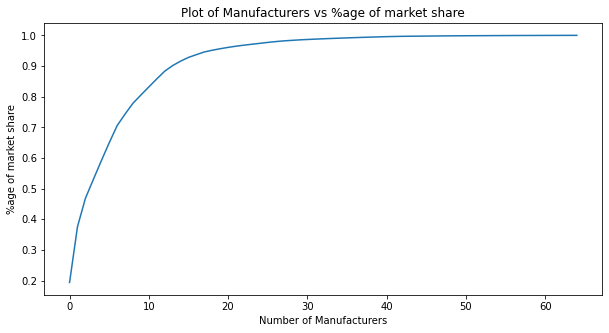

HYUNDAI          0.193959
TOYOTA           0.376025
MERCEDES-BENZ    0.468299
CHEVROLET        0.529857
FORD             0.590652
BMW              0.649412
HONDA            0.705437
NISSAN           0.743211
VOLKSWAGEN       0.778569
LEXUS            0.805342
SSANGYONG        0.831733
KIA              0.857806
OPEL             0.882989
MITSUBISHI       0.901304
SUBARU           0.915739
AUDI             0.928076
MAZDA            0.937043
JEEP             0.945819
DODGE            0.951479
FIAT             0.956312
Name: Manufacturer, dtype: float64


In [387]:
#Let us check the market share of car manufacturers
y = train_df.Manufacturer.value_counts(normalize=True).cumsum()
x = len(y)
plt.figure(figsize=(10,5))
plt.plot(range(x),y);
plt.title('Plot of Manufacturers vs %age of market share')
plt.xlabel('Number of Manufacturers')
plt.ylabel('%age of market share')
plt.show()
print(y.head(20))

* 20 manufacturers hold more than 96% of the market share according to the train data

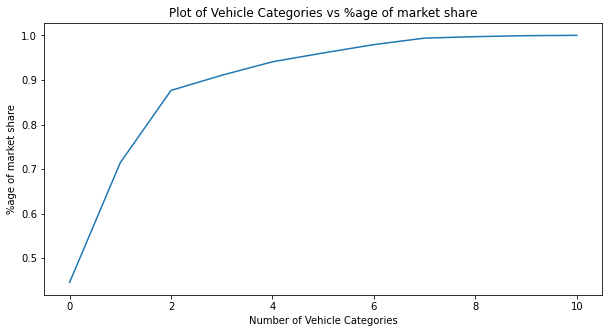

Sedan          0.445787
Jeep           0.714467
Hatchback      0.876502
Minivan        0.910461
Coupe          0.940731
Universal      0.960509
Microbus       0.979269
Goods wagon    0.993831
Pickup         0.997075
Cabriolet      0.999300
Limousine      1.000000
Name: Category, dtype: float64


In [390]:
#Lets do the same analysis for vehicle categories
y = train_df.Category.value_counts(normalize=True).cumsum()
x = len(y)
plt.figure(figsize=(10,5))
plt.plot(range(x),y);
plt.title('Plot of Vehicle Categories vs %age of market share')
plt.xlabel('Number of Vehicle Categories')
plt.ylabel('%age of market share')
plt.show()
print(y.head(20))

* From above we can see that Sedan, Jeep, Hatchback, Minivan and Coupe hold 95% of market

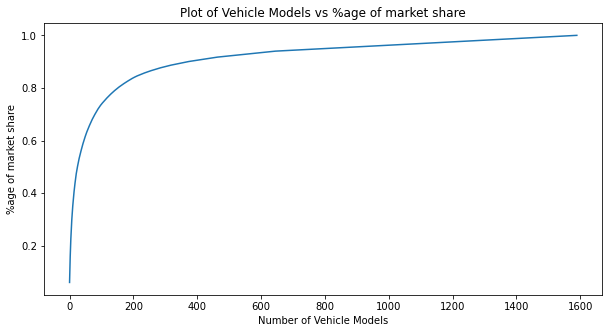

In [391]:
#Lets do the same analysis for vehicle models
y = train_df.Model.value_counts(normalize=True).cumsum()
x = len(y)
plt.figure(figsize=(10,5))
plt.plot(range(x),y);
plt.title('Plot of Vehicle Models vs %age of market share')
plt.xlabel('Number of Vehicle Models')
plt.ylabel('%age of market share')
plt.show()

In [392]:
print(y.head())

Prius       0.060159
Sonata      0.112369
Elantra     0.158156
Camry       0.195103
Santa FE    0.226010
Name: Model, dtype: float64


In [393]:
train_df.columns

Index(['Price', 'Levy', 'Manufacturer', 'Model', 'ProdYear', 'Category',
       'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage', 'Cylinders',
       'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color', 'Airbags'],
      dtype='object')

* Top 5 popular models hold almost quarter of the market share

Let us look at few of the other attributes

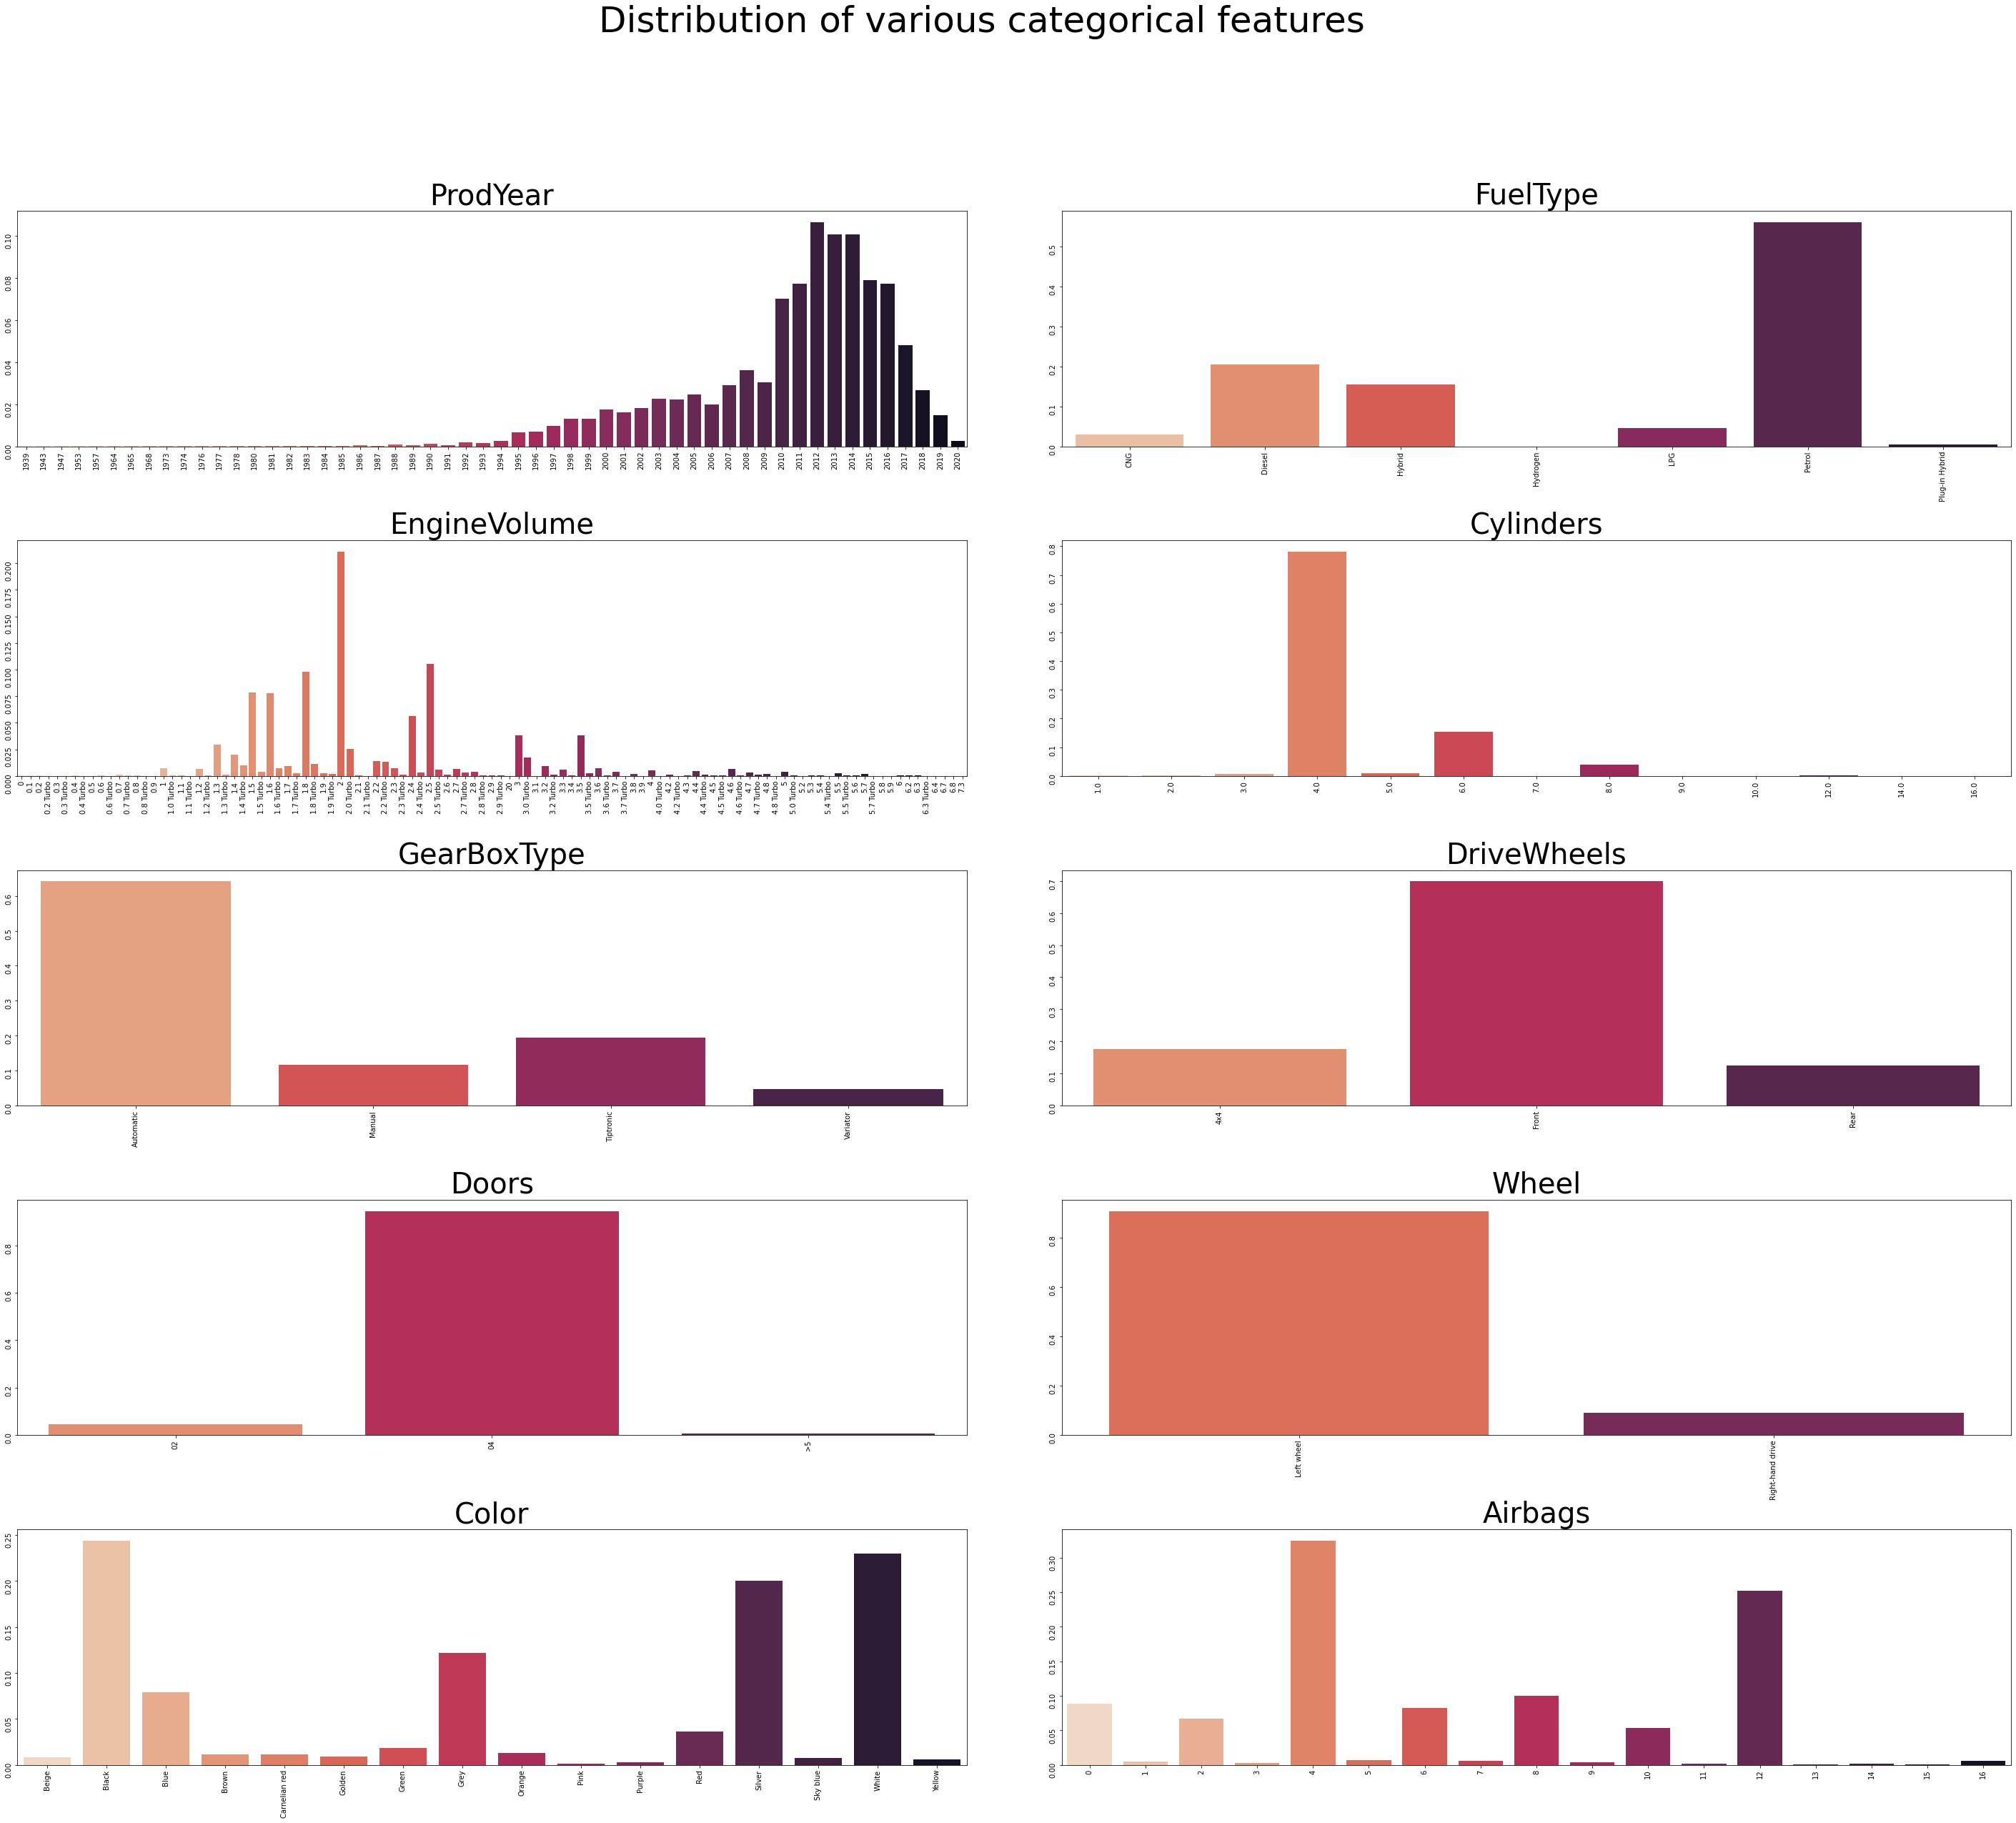

In [394]:
cat_cols = ['ProdYear', 'FuelType','EngineVolume', 'Cylinders','GearBoxType',
            'DriveWheels','Doors','Wheel','Color', 'Airbags']
fig,axes = plt.subplots(5,2,figsize=(50,40))
fig.subplots_adjust(wspace=0.1, hspace=0.4)
fig.suptitle('Distribution of various categorical features', fontsize=50)
axes = axes.ravel()

#plotting bar charts of value counts by sorting the index of value_counts series
for i, col in enumerate(cat_cols):
    sns.barplot(ax=axes[i], data=train_df, y=train_df[col].value_counts(normalize=True).sort_index(ascending=True).values, 
                                x=train_df[col].value_counts().sort_index(ascending=True).index, palette='rocket_r')
    axes[i].set_title(col, fontsize=40)
    axes[i].xaxis.get_label().set_fontsize(30)
    axes[i].tick_params(labelrotation=90)

Double-clicking any of the plots will zoom in on the images.
* Production year is skewed on the left which says that most of the cars were manufactured between 2008 and 2019
* Most of the common engine volume types are not the Turbo engines('2', '2.5', '1.8', '1.6', '1.5', '3.5', '2.4', '3', '1.3') which account for almost 75%. The most commomn turbo engine is 2.0 which is the 10th most common.
* Most fo the customers go for automatic or triptonic.
* As expected 4 doors is the most common configuration customers go for.
* Customers prioritize safety which is why the most common number for airbags are 4 and 12 and both are equal at 30% each.
* Customers go for petrol cars but when it comes to choose between hybrid and diesel, they go for both equally.
* Most common number of cylinders is 4 in more than 70% of the cars.

Let's look at some of the continuous variables

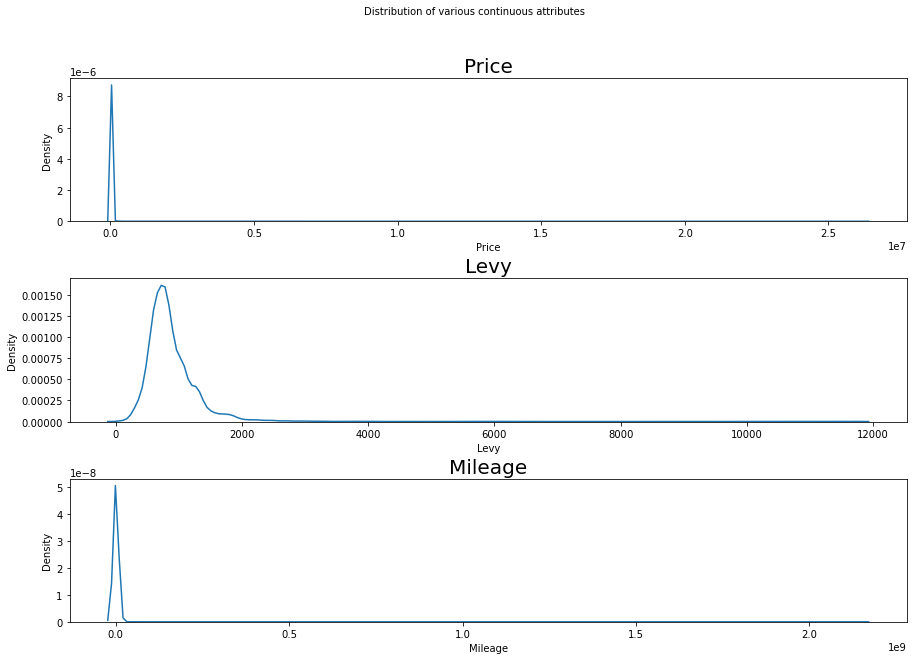

In [395]:
cont_cols = ['Price', 'Levy','Mileage']
fig,axes = plt.subplots(3,1,figsize=(15,10))
fig.subplots_adjust(wspace=0.1, hspace=0.4)
fig.suptitle('Distribution of various continuous attributes', fontsize=10)
axes = axes.ravel()

#plotting bar charts of value counts by sorting the index of value_counts series
for i, col in enumerate(cont_cols):
    sns.kdeplot(x = col, data=train_df, ax = axes[i])
    axes[i].set_title(col, fontsize=20)
#     axes[i].xaxis.get_label().set_fontsize(30)
#     axes[i].tick_params(labelrotation=90)

* All the three continuous variables are right skewed and the linear models work best with normaly distributed data. Some kind of transformtions like log transformations can be done on these variables. We can also try removing outliers, but looks like only outliers on the far right end can be removed which will not help us to transform the data to normaly distributed one. Let's check by implementing log transformation.

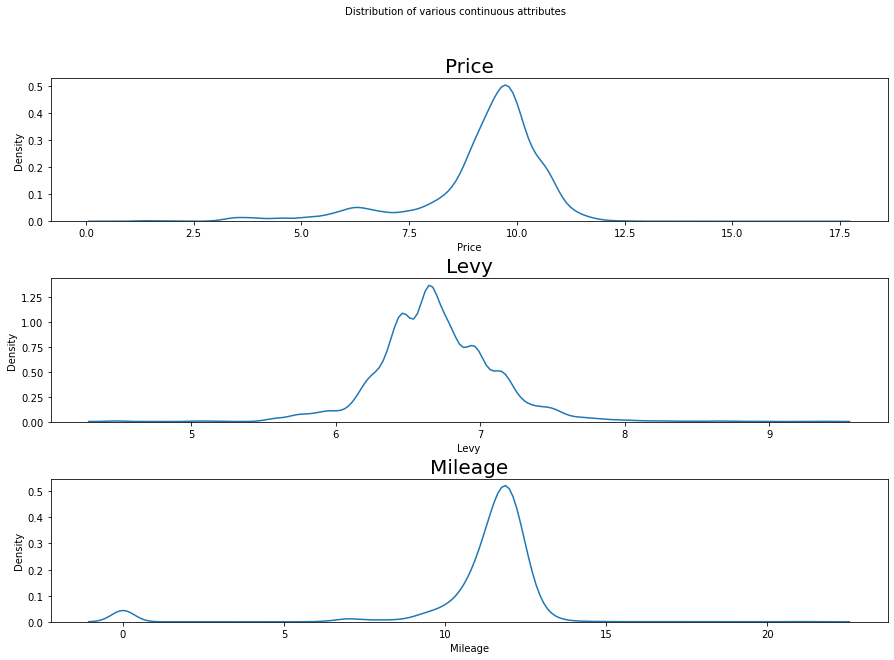

In [396]:
cont_cols = ['Price', 'Levy','Mileage']
fig,axes = plt.subplots(3,1,figsize=(15,10))
fig.subplots_adjust(wspace=0.1, hspace=0.4)
fig.suptitle('Distribution of various continuous attributes', fontsize=10)
axes = axes.ravel()

#plotting bar charts of value counts by sorting the index of value_counts series
for i, col in enumerate(cont_cols):
    sns.kdeplot(np.log1p(train_df[col]), ax = axes[i]) # ln(1+x) to counter value of 0.
    axes[i].set_title(col, fontsize=20)
#     axes[i].xaxis.get_label().set_fontsize(30)
#     axes[i].tick_params(labelrotation=90)

* The data looks close to a normaly distributed data except for the levy as we have not imputed the missing values for levy yet.
* We can also use Power Transformers like Box-Cox and Yeo-Johnson transformations to transformed the skewed data to a normaly ditributed one. Box-Cox can only be applied to a strictly positive number and since Mileage column has 0, we have to use yeo-johnson

In [403]:
#before and after transformation plots
def plots(df, var, t):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])
    
    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0])

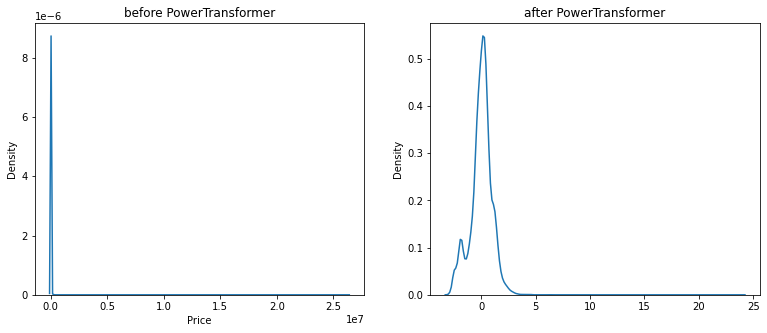

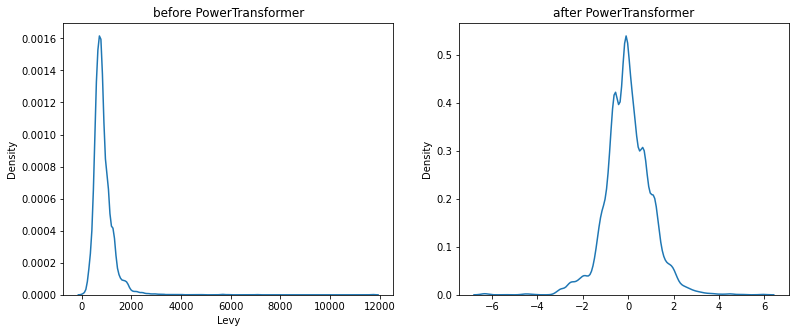

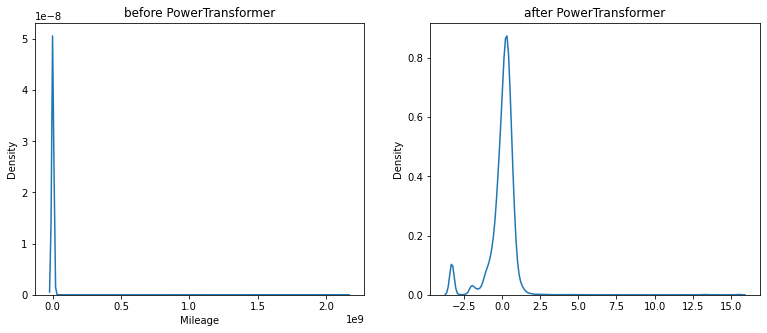

In [409]:
columns = ['Price','Levy','Mileage']
for col in columns:
    plots(train_df, col, preprocessing.PowerTransformer(method='yeo-johnson'))

* Let us now look how the features are related with the target variable

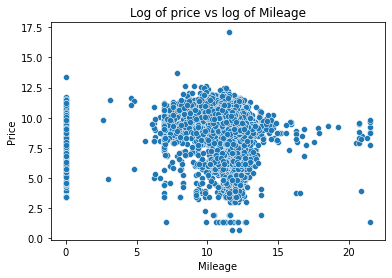

In [397]:
sns.scatterplot(x = np.log1p(train_df.Mileage), y=np.log1p(train_df.Price));
plt.title('Log of price vs log of Mileage');

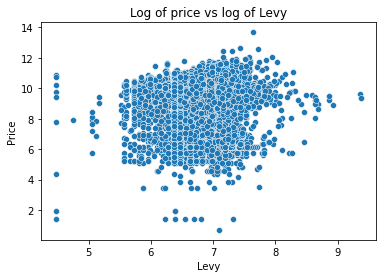

In [398]:
sns.scatterplot(x = np.log1p(train_df.Levy), y=np.log1p(train_df.Price));
plt.title('Log of price vs log of Levy');

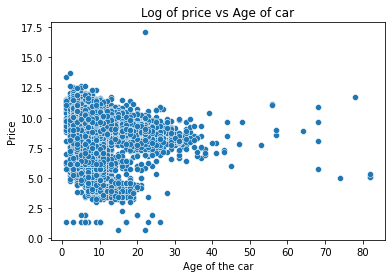

In [399]:
sns.scatterplot(x = 2021 - train_df.ProdYear, y=np.log1p(train_df.Price));
plt.title('Log of price vs Age of car')
plt.xlabel('Age of the car');

* Lets look at different distributions of categorical features with respect to the target variables

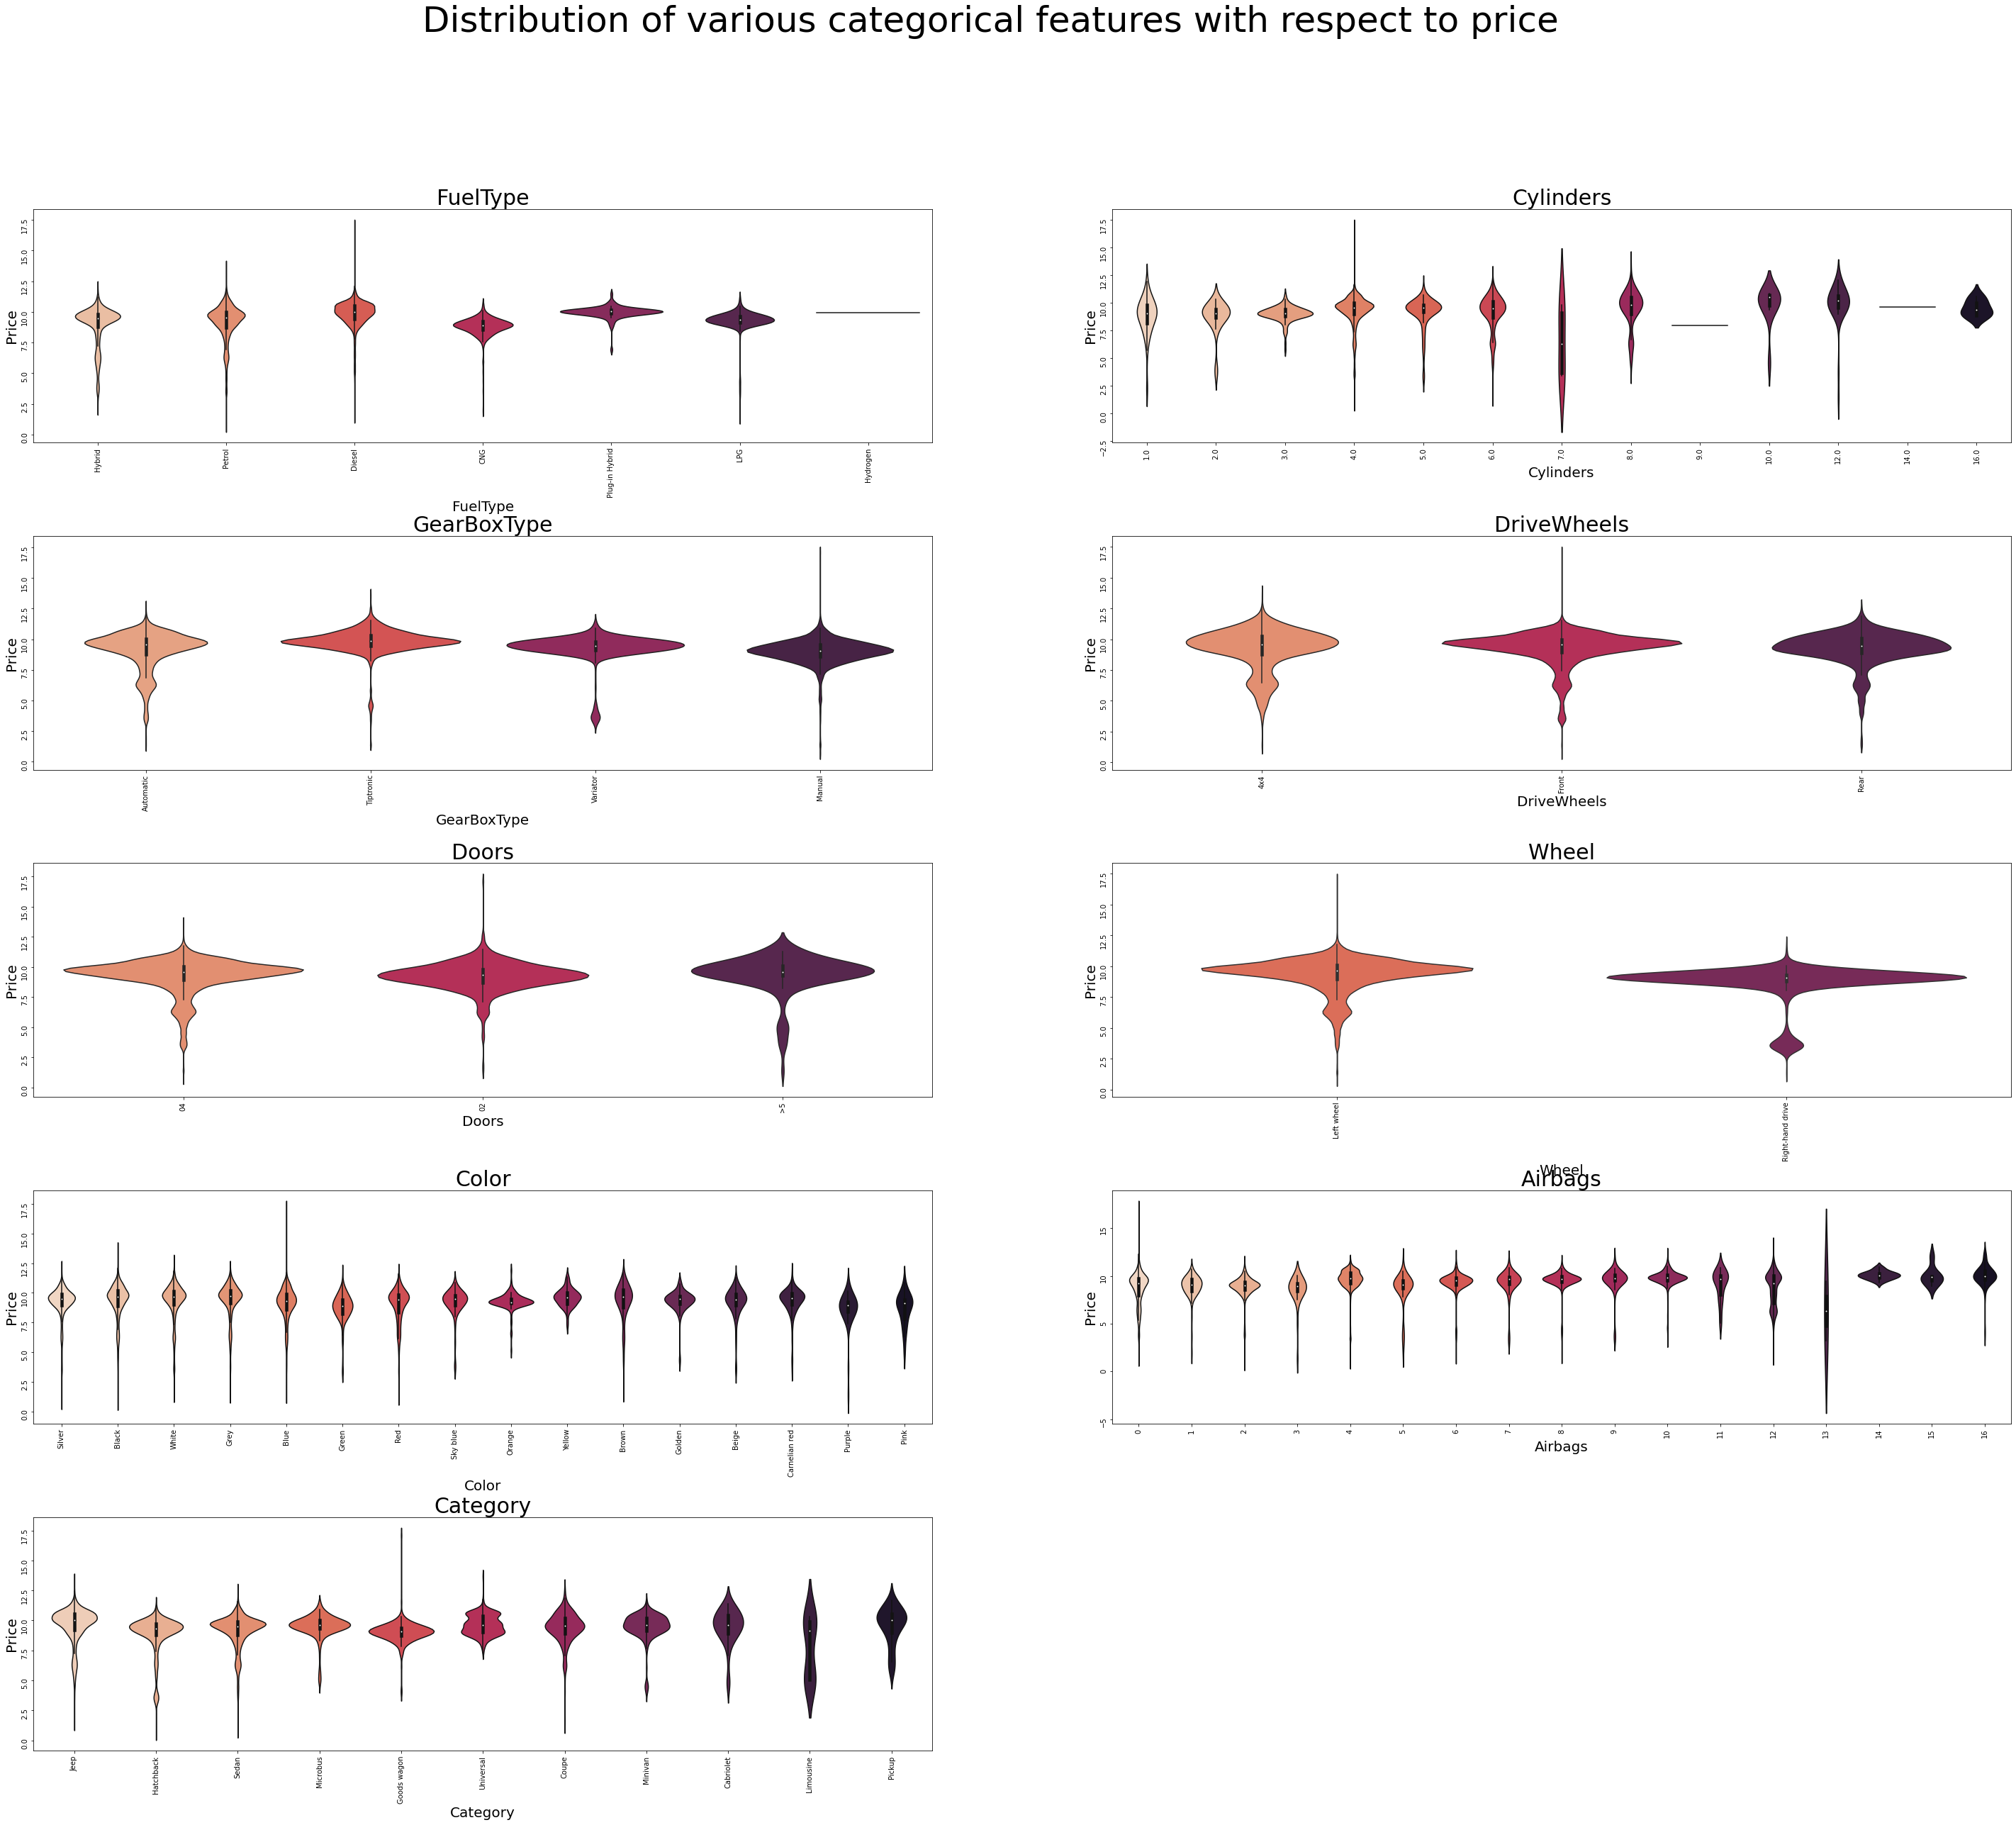

In [400]:
cat_cols = ['FuelType','Cylinders','GearBoxType',
            'DriveWheels','Doors','Wheel','Color', 'Airbags', 'Category']
fig,axes = plt.subplots(5,2,figsize=(50,40))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
fig.suptitle('Distribution of various categorical features with respect to price', fontsize=50)
axes = axes.ravel()

#plotting bar charts of value counts by sorting the index of value_counts series
for i, col in enumerate(cat_cols):
    sns.violinplot(ax=axes[i], data=train_df, y=np.log1p(train_df.Price), x=train_df[col], palette='rocket_r')
    axes[i].set_title(col, fontsize=30)
    axes[i].xaxis.get_label().set_fontsize(20)
    axes[i].yaxis.get_label().set_fontsize(20)
    axes[i].tick_params(labelrotation=90)
fig.delaxes(axes[-1])

* Violin plots show us the same information as box plots and more. They also show us the ditribution of various values of a categorical features with the target variable.

* Lets perform some statistical test - ANOVA Analysis to check if there is a variability in features w.r.t to log of price.
* The null hypothesis says that there is no variability and the alternate hypothesis says that there is a variability. With 95% confidence level if p-value is less than 0.05 we can sat that null hypothesis doesnot hold true.

In [401]:
cols = ['Manufacturer','Model','ProdYear','FuelType','Cylinders','GearBoxType','EngineVolume',
            'DriveWheels','Doors','Wheel','Color', 'Airbags', 'Category']

# t-test and anova assumes data to normally distributed

tmp = train_df[cols].copy()

y = train_df.Price.apply(np.log) # log of price

for col in cols:
    cat_y = []
    for cat in tmp[col].unique():
        cat_y.append(y[tmp[col]==cat])
    print(f'{col}:\n{stats.f_oneway(*cat_y)}') #one-way ANOVA test

Manufacturer:
F_onewayResult(statistic=17.308540142618476, pvalue=7.006754083918134e-183)
Model:
F_onewayResult(statistic=2.490063124092019, pvalue=8.392327596333684e-167)
ProdYear:
F_onewayResult(statistic=16.48775986097557, pvalue=1.680901352037256e-144)
FuelType:
F_onewayResult(statistic=137.5227810386416, pvalue=1.8042769776751297e-170)
Cylinders:
F_onewayResult(statistic=5.770860633945649, pvalue=4.677441269752952e-10)
GearBoxType:
F_onewayResult(statistic=214.05931237185854, pvalue=4.20185324943632e-136)
EngineVolume:
F_onewayResult(statistic=13.307994459891146, pvalue=1.2631380817468087e-215)
DriveWheels:
F_onewayResult(statistic=0.9224583154944219, pvalue=0.3975620739371245)
Doors:
F_onewayResult(statistic=0.5871784476116678, pvalue=0.5559057469319675)
Wheel:
F_onewayResult(statistic=279.16802977755987, pvalue=3.913786456896586e-62)
Color:
F_onewayResult(statistic=7.994103514035724, pvalue=2.3601810300012692e-18)
Airbags:
F_onewayResult(statistic=114.11370203876743, pvalue=0.0)

* The more the F-statistic the less is the p-value and we can say that there is definitely variability in the means of the features. From the above it can be seen that doors and drive wheels have very high p values and very low F-statistic which shows that these two features doesn't have high variability to explain the target variable Price.

### Test regression methods using PyCaret

In [411]:
train_df.ProdYear = 2021 - train_df.ProdYear # getting the age of the car

In [412]:
train_df.head()

,Price,Levy,Manufacturer,Model,ProdYear,Category,LeatherInterior,FuelType,EngineVolume,Mileage,Cylinders,GearBoxType,DriveWheels,Doors,Wheel,Color,Airbags
0,13328,1399.0,LEXUS,RX 450,11,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04,Left wheel,Silver,12
1,16621,1018.0,CHEVROLET,Equinox,10,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,04,Left wheel,Black,8
2,8467,NaN,HONDA,FIT,15,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04,Right-hand drive,Black,2
3,3607,862.0,FORD,Escape,10,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04,Left wheel,White,0
4,11726,446.0,HONDA,FIT,7,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04,Left wheel,Silver,4


In [418]:
#setting up the pipeline for pycaret
# We are using Iteratve Imputer from sklearn instead of Simple Imputer. Iterative Imputer uses light-gbm
#Since it doesnot detect airbags and mileage column as numeric, entering airbags column as numeric
# Model and Engine Volume are designated as high cardibnality feature and replaced with their frequency. Another way is 
#to use K-Means to cluster the high cardinaly features and assign the cluster label.
#using 10-fold cross validation while training

exp_reg =setup(data = train_df, target = 'Price', session_id=123,imputation_type='iterative',
                   high_cardinality_features=['Manufacturer','Model','EngineVolume'],high_cardinality_method='clustering',
                  normalize = True, transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   experiment_name = 'cars',numeric_features=['Airbags','Mileage'], train_size=0.95)

,Description,Value
0,session_id,123
1,Target,Price
2,Original Data,"(15725, 17)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,11
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,clustering
9,Transformed Train Set,"(14938, 55)"


* Because we used clustering while handling high cardinality features, the number of columns after preprocessing didn't bombard, which would happen if we had used one hot encoding.

In [419]:
# selects the best three model by using RMSLE score
# here the vanilla models are used without any hyperparameter tuning
model = compare_models(sort='RMSLE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,7739.1119,46522583055.8248,80685.0470,0.4771,1.1014,11.0127,6.2940
catboost,CatBoost Regressor,8018.4781,46522496308.0850,81108.0780,0.4423,1.1021,11.9282,5.5430
lightgbm,Light Gradient Boosting Machine,8013.5690,46501412223.4898,80425.7967,0.4950,1.1071,10.8936,0.3440
xgboost,Extreme Gradient Boosting,8209.4150,46529020085.6000,81268.0460,0.4334,1.1113,11.1919,3.2280
et,Extra Trees Regressor,7947.8738,46560523607.4406,81723.4196,0.3297,1.1482,10.2991,6.6290
gbr,Gradient Boosting Regressor,8952.3185,46545410246.5307,81967.8052,0.3811,1.1666,12.2831,1.8510
knn,K Neighbors Regressor,8831.9759,46560327156.5262,82210.9652,0.3660,1.1924,11.0550,1.0440
lr,Linear Regression,11026.1877,46611443747.2000,83766.5778,0.2385,1.3224,13.1592,2.1470
ridge,Ridge Regression,11025.8653,46611401988.8000,83766.9130,0.2385,1.3224,13.1632,0.0430
br,Bayesian Ridge,11025.3496,46610567065.3306,83772.4434,0.2380,1.3225,13.2227,0.1040


In [420]:
#let's remove the high cardinality parameter and try once again
#here we can see that transformed train has 700 features, possibly due to onehot instead of clustering

exp_reg1 =setup(data = train_df, target = 'Price', session_id=123,imputation_type='iterative',
                  normalize = True, transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   experiment_name = 'cars',numeric_features=['Airbags','Mileage'], train_size=0.95)

,Description,Value
0,session_id,123
1,Target,Price
2,Original Data,"(15725, 17)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,11
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(14938, 700)"


In [421]:
# selects the best three model by using RMSLE score
# here the vanilla models are used without any hyperparameter tuning
model1 = compare_models(sort='RMSLE', n_select=2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,7264.8081,46526169630.8752,80935.3588,0.4478,1.0685,10.1560,29.0120
lightgbm,Light Gradient Boosting Machine,7670.3836,46485055013.3086,79823.0608,0.5333,1.0824,11.3933,0.7860
catboost,CatBoost Regressor,7991.7442,47568411623.2784,90834.7472,-2.3839,1.0882,12.0870,8.6400
xgboost,Extreme Gradient Boosting,8114.5038,47789578072.0000,92386.9615,-2.8621,1.0932,11.7970,28.4630
et,Extra Trees Regressor,7469.4316,47289590178.2909,87537.2195,-1.6458,1.1084,9.8892,43.9090
knn,K Neighbors Regressor,8208.2193,46554215793.0259,82065.2769,0.3764,1.1475,9.2442,7.6560
gbr,Gradient Boosting Regressor,9101.8481,46989634008.1983,87146.2861,-0.8099,1.1659,11.9139,12.2010
br,Bayesian Ridge,10000.8079,46561144655.6370,82371.6479,0.3542,1.2645,12.3765,2.7270
ridge,Ridge Regression,9976.6501,46558333491.2000,82309.0549,0.3591,1.2649,12.2873,0.2370
omp,Orthogonal Matching Pursuit,10374.0152,46567883360.1077,82799.7934,0.3212,1.2882,12.2460,0.2590


In [425]:
rf = model[0] # random forest
lightgbm = model[1] #lightgbm
catboost = create_model('catboost', verbose=False) #catboost

In [426]:
#blending the above three models by taking average
blender = blend_models(estimator_list = [rf, lightgbm, catboost])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,23549.4718,463213938724.1959,680598.2212,-0.0011,1.0724,13.0571
1,5121.5925,88940300.0807,9430.8165,0.7029,1.0807,9.8484
2,5676.9829,126157478.4873,11231.9846,0.6687,1.1491,9.7622
3,5387.9202,242428336.1720,15570.1103,0.5368,1.1103,33.1060
4,5792.5612,511167755.5205,22609.0193,0.3487,1.0596,6.4658
5,6006.9829,463963701.9050,21539.8167,-0.2159,1.0511,6.1624
6,7153.5667,2486616675.9867,49865.9872,-5.7270,0.9944,4.4491
7,5028.2644,86145420.5369,9281.4557,0.6834,1.0429,10.5219
8,5663.3008,153367753.2189,12384.1735,0.6032,1.0341,5.3404
9,5640.7080,164950079.2200,12843.2893,0.5881,1.0923,12.2323


In [436]:
test = pd.read_csv('test.csv') # importing the train set and performing the initial set of operations that we performed on 
                                    train set

In [437]:
test.columns=['ID','Levy', 'Manufacturer', 'Model', 'ProdYear',
       'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage',
       'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color',
       'Airbags','Price']

In [438]:
test.drop(['ID','Price'], axis=1, inplace=True)

In [439]:
test.Levy = test.Levy.replace('-',np.nan).astype('float')
test.Mileage = test.Mileage.replace(' km','',regex=True).astype('int')

In [441]:
test.ProdYear = 2021-test.ProdYear

In [442]:
test.Doors = test.Doors.replace(r'-[a-zA-Z]{3}','',regex=True)

In [443]:
test.head()

,Levy,Manufacturer,Model,ProdYear,Category,LeatherInterior,FuelType,EngineVolume,Mileage,Cylinders,GearBoxType,DriveWheels,Doors,Wheel,Color,Airbags
0,NaN,VOLKSWAGEN,Golf,9,Hatchback,No,Diesel,2.0 Turbo,0,4,Manual,Front,02,Left wheel,Grey,10
1,NaN,HYUNDAI,Sonata,9,Sedan,Yes,Petrol,2.4,26000,4,Tiptronic,Front,04,Left wheel,Grey,10
2,NaN,NISSAN,Tiida,16,Sedan,No,Petrol,1.5,168000,4,Automatic,Front,04,Right-hand drive,Sky blue,8
3,975.0,VOLVO,XC90,9,Jeep,Yes,Petrol,3.2,143000,6,Automatic,4x4,04,Left wheel,Blue,12
4,NaN,OPEL,Astra,28,Hatchback,No,Petrol,1.6,200000,4,Manual,Front,04,Left wheel,Black,0


In [444]:
y_pred = predict_model(blender,test,round=2) #calling the blender model to predict y

Finished loading model, total used 100 iterations


In [ ]:
y=y_pred.Label.values
submission = pd.DataFrame(np.array(y).reshape((-1,1)), columns=['Price'])

In [ ]:
submission.to_csv('my_submission_file.csv', index=False)

* The hyperparameters of the above models have not been tuned because of lack of hardware. Tried multiple cloud service providers like paperspace, google cloud for multiple core instances but there were lot of dependancy issues and also didnot allow to run more than 1 jobs at a time. 
* Another method we can use here is stacking of models 